## Smoothness Learning

In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready, config

from algos.ppo import PPO_make_train

from jax.scipy.integrate import trapezoid
from jax.scipy.special import erf

from envs.photon_langevin_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Seeding all Random Number Generation during the RL Training for Reproducibility

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 25.0
chi = 0.65
kerr = 0.002
gamma = 1/100
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
rough_max_photons = 31
rough_max_amp_scaled = 1/0.43
actual_max_photons = rough_max_photons * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {rough_max_photons}")
print(f"Actual Max Photons: {actual_max_photons}")
ideal_photon = 1e-2
scaling_factor = 7.5
gamma_I = 1/500
num_t1 = 12.0
photon_gamma = 1/2000
init_fid = 1 - 1e-3

batchsize = 64
num_envs = 8
num_updates = 1000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 256,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": False,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 31
Actual Max Photons: 30.573151382405857


## Kappa Variance

In [7]:
num_exp = 3
batch_rng = jax.random.split(_rng, num_exp)
rng, _rng = jax.random.split(rng)

ones_arr = np.ones(num_exp)

kappa_vals = np.array([kappa * (1 - 0.1), kappa, kappa * (1 + 0.1)])
chi_vals = chi * ones_arr
kerr_vals = kerr * ones_arr
gamma_vals = gamma * ones_arr
time_coef_vals = time_coeff * ones_arr
snr_coef_vals = snr_coeff * ones_arr
smoothness_coef_vals = smoothness_coeff * ones_arr
rough_max_photons_vals = rough_max_photons * ones_arr
actual_max_photons_vals = actual_max_photons * ones_arr
rough_max_amp_scaled_vals = rough_max_amp_scaled * ones_arr
ideal_photon_vals = ideal_photon * ones_arr
scaling_factor_vals = scaling_factor * ones_arr
gamma_I_vals = gamma_I * ones_arr
num_t1_vals = num_t1 * ones_arr
photon_gamma_vals = photon_gamma * ones_arr
init_fid_vals = init_fid * ones_arr

In [8]:
vmap_index_list = np.zeros(17, dtype=np.int8).tolist() + [None] * 2

multi_kappa_train = jit(
    vmap(PPO_make_train(config), in_axes=vmap_index_list), 
    static_argnums=(-2, -1)
)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
multi_kappa_result = multi_kappa_train(
    batch_rng, 
    kappa_vals, 
    chi_vals, 
    kerr_vals,
    gamma_vals,
    time_coef_vals,
    snr_coef_vals,
    smoothness_coef_vals,
    rough_max_photons_vals,
    actual_max_photons_vals,
    rough_max_amp_scaled_vals,
    ideal_photon_vals,
    scaling_factor_vals,
    gamma_I_vals,
    num_t1_vals,
    photon_gamma_vals,
    init_fid_vals,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates


In [7]:
# Extracting Results

metrics = multi_kappa_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]

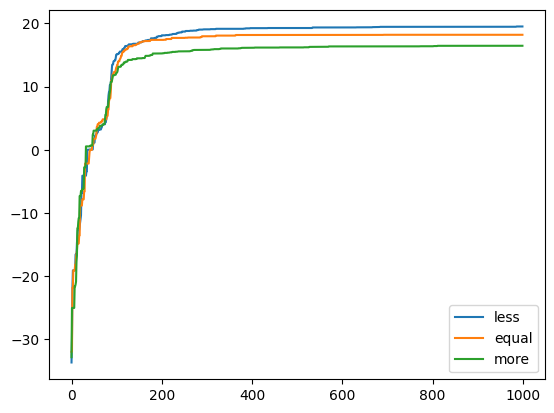

In [8]:
plt.plot(max_rewards[0,:,-1], label='less')
plt.plot(max_rewards[1,:,-1], label='equal')
plt.plot(max_rewards[2,:,-1], label='more')
plt.legend()
plt.show()

In [19]:
def t1_duration(kappa, res_scale_factor, tau_0):
    return (
        -2
        / kappa
        * jnp.log(1 - 1 / res_scale_factor * (1.0 - jnp.exp(-0.5 * kappa * tau_0)))
    )


def t3_duration(kappa, res_scale_factor):
    return -2 / kappa * jnp.log(res_scale_factor / (1.0 + res_scale_factor))

def pF(x):
    return -jnp.log10(1 - x)

def get_fidelity_curves(
    kappa,
    chi,
    N0,
    res_scale_factor,
    tau_0,
    init_fid,
    gamma_M,
    b,
    mu_s,
    num_t1,
    plot_curves: Optional[bool] = True,
    action: Optional[jnp.ndarray] = None
):  
    batch_size = 1
    ind = 0

    env = BatchedPhotonLangevinReadoutEnv(
        kappa=kappa,
        chi=chi,
        batchsize=batch_size,
        kerr=kerr,
        gamma=gamma,
        time_coeff=time_coeff,
        snr_coeff=snr_coeff,
        smoothness_coeff=smoothness_coeff,
        rough_max_photons=N0,
        actual_max_photons=actual_max_photons,
        rough_max_amp_scaled=res_scale_factor,
        ideal_photon=ideal_photon,
        scaling_factor=scaling_factor,
        gamma_I=gamma_I,
        num_t1=num_t1,
        photon_gamma=photon_gamma,
        init_fid=init_fid
    )

    ts = env.ts_sim

    batch_action = jnp.tile(action, (batch_size, 1))
    batched_results = env.batched_results(batch_action)
    max_pf, max_photons, photon_reset_time, smoothness_val, b_pf, b_higher_photons = env.batched_extract_values(batched_results, batch_action)
    real_pf = b_pf[0]

    t1 = t1_duration(kappa, res_scale_factor, tau_0)
    t3 = t3_duration(kappa, res_scale_factor)
    decay_factor = 1. - jnp.exp(-0.5 * kappa * tau_0)

    u = res_scale_factor
    N0_u = N0 * u ** 2
    N0_f = N0 * decay_factor ** 2

    integrated_decay_t1 = (gamma_M + b * N0_u) * t1 + 4 * b * N0_u / kappa * (jnp.exp(-0.5*kappa*t1) - 1.) - b * N0_u / kappa * (jnp.exp(-kappa * t1) - 1.)
    fidelity_high_t1 = init_fid * jnp.exp(-integrated_decay_t1)

    fidelity_i2 = fidelity_high_t1 * jnp.exp(-(gamma_M + b * N0_f) * (ts - t1))
    b1 = u * (chi / kappa * (1. - jnp.exp(-0.5 * kappa * t1)) - 0.5 * chi * t1 * jnp.exp(-0.5 * kappa * t1)) / decay_factor

    separation_i2 = 2 * jnp.sqrt(N0_f) * (
        b1 * jnp.exp(-0.5 * kappa * (ts - t1)) + chi / kappa * (1. - jnp.exp(-0.5 * kappa * (ts - t1)))
    )
    opt_fidelity = 0.5 * (1 + erf(mu_s * separation_i2)) * fidelity_i2

    integrated_decay_ts = (gamma_M + b * N0) * ts + 4 * b * N0 / kappa * (jnp.exp(-0.5 * kappa * ts) - 1.) - b * N0 / kappa * (jnp.exp(-kappa * ts) - 1.)
    fidelity_normal = init_fid * jnp.exp(-integrated_decay_ts)
    separation_normal = 2 * jnp.sqrt(N0) * (
        chi / kappa * (1. - jnp.exp(-0.5 * kappa * ts)) - 0.5 * chi * ts * jnp.exp(-0.5 * kappa * ts)
    )
    exp_fidelity = 0.5 * (1 + erf(mu_s * separation_normal)) * fidelity_normal

    integrated_high_decay_ts = (gamma_M + b * N0_u) * ts + 4 * b * N0_u / kappa * (jnp.exp(-0.5 * kappa * ts) - 1.) - b * N0_u / kappa * (jnp.exp(-kappa * ts) - 1.)
    fidelity_high = init_fid * jnp.exp(-integrated_high_decay_ts)
    separation_high = 2 * jnp.sqrt(N0_u) * (
        chi / kappa * (1. - jnp.exp(-0.5 * kappa * ts)) - 0.5 * chi * ts * jnp.exp(-0.5 * kappa * ts)
    )
    high_fidelity = 0.5 * (1 + erf(mu_s * separation_high)) * fidelity_high

    peak_opt_fidelity = jnp.max(opt_fidelity)
    peak_opt_fidelity_time = ts[jnp.argmax(opt_fidelity)]

    peak_exp_fidelity = jnp.max(exp_fidelity)
    peak_exp_fidelity_time = ts[jnp.argmax(exp_fidelity)]

    peak_real_fidelity = jnp.max(real_pf)
    peak_real_fidelity_time = ts[jnp.argmax(real_pf)]

    peak_high_fidelity = jnp.max(high_fidelity)
    peak_high_fidelity_time = ts[jnp.argmax(high_fidelity)]

    max_fidelity = init_fid * jnp.exp(-gamma_M * ts)

    if plot_curves:
        fig, ax = plt.subplots(1, figsize=(10., 8.0))

        ax.plot(ts, pF(exp_fidelity), label='exp pF', color='red')
        ax.plot(ts, pF(opt_fidelity), label='opt pF', color='green')
        ax.plot(ts, pF(max_fidelity), label='max pF', color='blue')
        ax.plot(ts, pF(high_fidelity), label='high pF', color='purple')
        ax.plot(ts, real_pf, label='action pF', color='orange')
        ax.axvline(x=t1, color='grey', linestyle='dashed', label='t1')
        ax.axvline(x=peak_exp_fidelity_time, color='red', linestyle='dashed', label=f'exp t2: {int(peak_exp_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_high_fidelity_time, color='purple', linestyle='dashed', label=f'high t2: {int(peak_high_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_opt_fidelity_time, color='green', linestyle='dashed', label=f'opt t2: {int(peak_opt_fidelity_time * 1e3) / 1e3}us')
        ax.axvline(x=peak_real_fidelity_time, color='orange', linestyle='dashed', label=f'real t2: {int(peak_real_fidelity_time * 1e3) / 1e3}us')
        ax.axhline(y=peak_exp_fidelity, color='red', linestyle='dashed', label=f'exp max fid: {int(peak_exp_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_high_fidelity, color='purple', linestyle='dashed', label=f'high max fid: {int(peak_high_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_opt_fidelity, color='green', linestyle='dashed', label=f'opt max fid: {int(peak_opt_fidelity * 1e3) / 1e3}')
        ax.axhline(y=peak_real_fidelity, color='orange', linestyle='dashed', label=f'real max fid: {int(peak_real_fidelity * 1e3) / 1e3}')
        ax.set_xlabel('Time (us)')
        ax.set_ylabel('pF')
        ax.set_title('pF vs Time (us)')
        ax.legend()

        print(f"Kappa: {kappa} MHz")
        print(f"1/kappa: {1000 * 1/kappa}ns")
        print(f"Normal Measurement Duration: {1000 * tau_0}ns")
        print(f"High Amp Duration (T1): {1000 * t1}ns")

        plt.show()

    return t1, peak_opt_fidelity_time, t3

def generate_A3R_waveform(
    kappa,
    chi,
    tau_0,
    t1,
    t2,
    t3,
    N0,
    u
):
    ts = jnp.linspace(0., num_t1 / kappa, 121)
    amp_2 = 1/u * (1. - jnp.exp(-0.5 * kappa * tau_0))

    A3R_action = jnp.heaviside(t1 - ts, 0.)
    A3R_action += amp_2 * (jnp.heaviside(t2 - ts, 0.) - jnp.heaviside(t1 - ts, 0.))
    A3R_action -= jnp.heaviside(t2 + t3 - ts, 0.) - jnp.heaviside(t2 - ts, 0.)
    A3R_action *= jnp.heaviside(t2 + t3 - ts, 0.)

    A3R_action *= 0.5 * u * jnp.sqrt(N0 * (kappa ** 2 + chi ** 2))

    return A3R_action, ts

## Chi Variance

In [10]:
num_exp = 3
batch_rng = jax.random.split(_rng, num_exp)
rng, _rng = jax.random.split(rng)

ones_arr = np.ones(num_exp)

kappa_vals = kappa * ones_arr
chi_vals = chi * np.array([1 - 0.1, 1, 1 + 0.1])
kerr_vals = kerr * ones_arr
gamma_vals = gamma * ones_arr
time_coef_vals = time_coeff * ones_arr
snr_coef_vals = snr_coeff * ones_arr
smoothness_coef_vals = smoothness_coeff * ones_arr
rough_max_photons_vals = rough_max_photons * ones_arr
actual_max_photons_vals = actual_max_photons * ones_arr
rough_max_amp_scaled_vals = rough_max_amp_scaled * ones_arr
ideal_photon_vals = ideal_photon * ones_arr
scaling_factor_vals = scaling_factor * ones_arr
gamma_I_vals = gamma_I * ones_arr
num_t1_vals = num_t1 * ones_arr
photon_gamma_vals = photon_gamma * ones_arr
init_fid_vals = init_fid * ones_arr

In [11]:
vmap_index_list = np.zeros(17, dtype=np.int8).tolist() + [None] * 2

multi_chi_train = jit(
    vmap(PPO_make_train(config), in_axes=vmap_index_list), 
    static_argnums=(-2, -1)
)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
multi_chi_result = multi_chi_train(
    batch_rng, 
    kappa_vals, 
    chi_vals, 
    kerr_vals,
    gamma_vals,
    time_coef_vals,
    snr_coef_vals,
    smoothness_coef_vals,
    rough_max_photons_vals,
    actual_max_photons_vals,
    rough_max_amp_scaled_vals,
    ideal_photon_vals,
    scaling_factor_vals,
    gamma_I_vals,
    num_t1_vals,
    photon_gamma_vals,
    init_fid_vals,
    batchsize, 
    num_envs)
print(f"time taken: {time.time() - start}")

Starting a Run of 1000 Updates
time taken: 613.9894132614136


In [12]:
# Extracting Results

chi_metrics = multi_chi_result["metrics"]

chi_max_actions = chi_metrics["action of max"]
chi_max_rewards = chi_metrics["max reward obtained"]
chi_max_photons = chi_metrics["photon at max"]
chi_max_pFs = chi_metrics["pF at max"]
chi_max_times = chi_metrics["photon time of max"]
chi_mean_rewards = chi_metrics["mean batch reward"]
chi_mean_pFs = chi_metrics["mean batch pF"]
chi_mean_photons = chi_metrics["mean batch photon"]
chi_mean_photon_times = chi_metrics["mean batch photon time"]

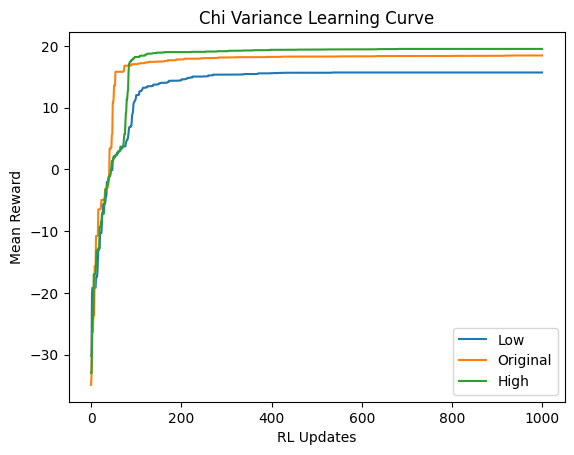

In [13]:
plt.plot(chi_max_rewards[0,:,-1], label='Low')
plt.plot(chi_max_rewards[1,:,-1], label='Original')
plt.plot(chi_max_rewards[2,:,-1], label='High')
plt.xlabel('RL Updates')
plt.ylabel('Mean Reward')
plt.title('Chi Variance Learning Curve')
plt.legend()
plt.show()

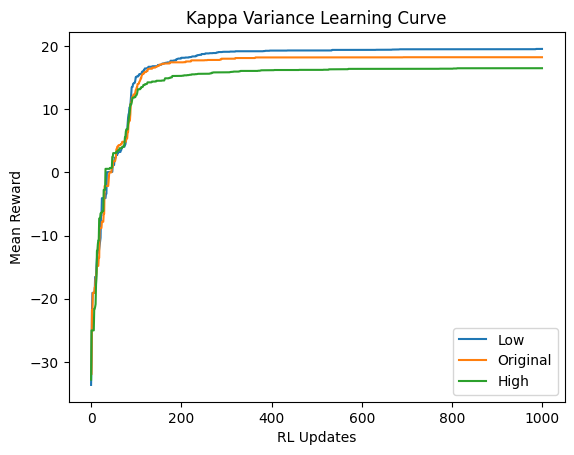

In [14]:
plt.plot(max_rewards[0,:,-1], label='Low')
plt.plot(max_rewards[1,:,-1], label='Original')
plt.plot(max_rewards[2,:,-1], label='High')
plt.xlabel('RL Updates')
plt.ylabel('Mean Reward')
plt.title('Kappa Variance Learning Curve')
plt.legend()
plt.show()

Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


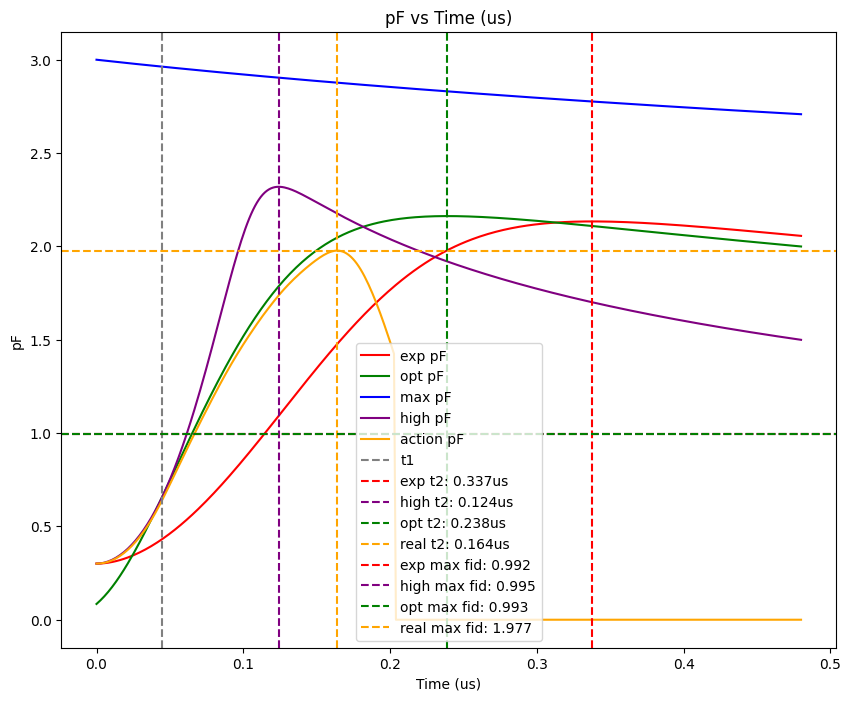

t1: 0.04455366098237813, t2: 0.23866666666666667, t3: 0.028613955541745277
Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


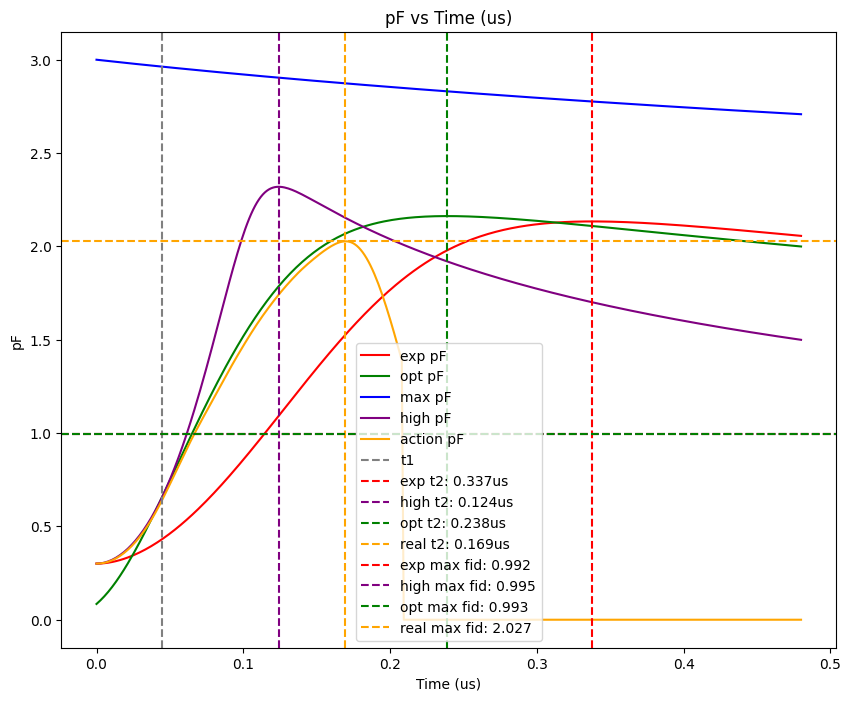

t1: 0.04455366098237813, t2: 0.23866666666666667, t3: 0.028613955541745277
Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


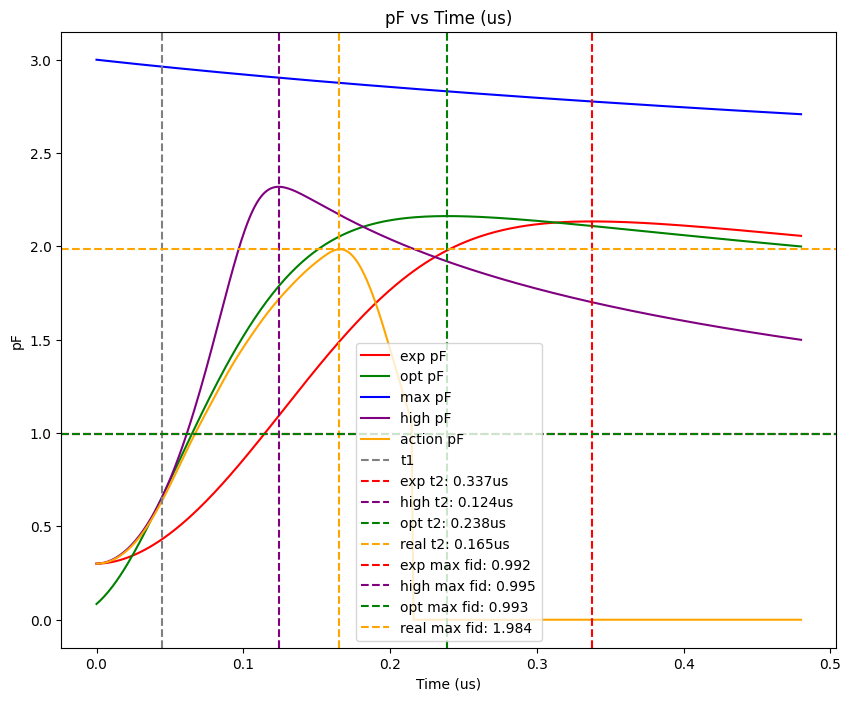

In [31]:
ind = 0
ts_low = jnp.linspace(0., num_t1 / (kappa * 0.9), 121)
ts_og = jnp.linspace(0., num_t1 / (kappa), 121)
ts_high = jnp.linspace(0., num_t1 / (kappa * 1.1), 121)

plot_curves = True

low_amp = 0.5 * kappa * 0.9 * jnp.sqrt(rough_max_photons)
normal_amp = 0.5 * kappa * jnp.sqrt(rough_max_photons)
high_amp = 0.5 * kappa * 1.1 * jnp.sqrt(rough_max_photons)

low_action = max_actions[0, -1, ind] / low_amp * normal_amp
normal_action = max_actions[1, -1, ind]
high_action = max_actions[2, -1, ind] / high_amp * normal_amp

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=low_action
)
print(f"t1: {t1}, t2: {t2}, t3: {t3}")
t2 = 0.16
low_kappa_A3R, low_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=normal_action
)

print(f"t1: {t1}, t2: {t2}, t3: {t3}")
t2 = 0.16
normal_kappa_A3R, normal_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=high_action
)
t2 = 0.16
high_kappa_A3R, high_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

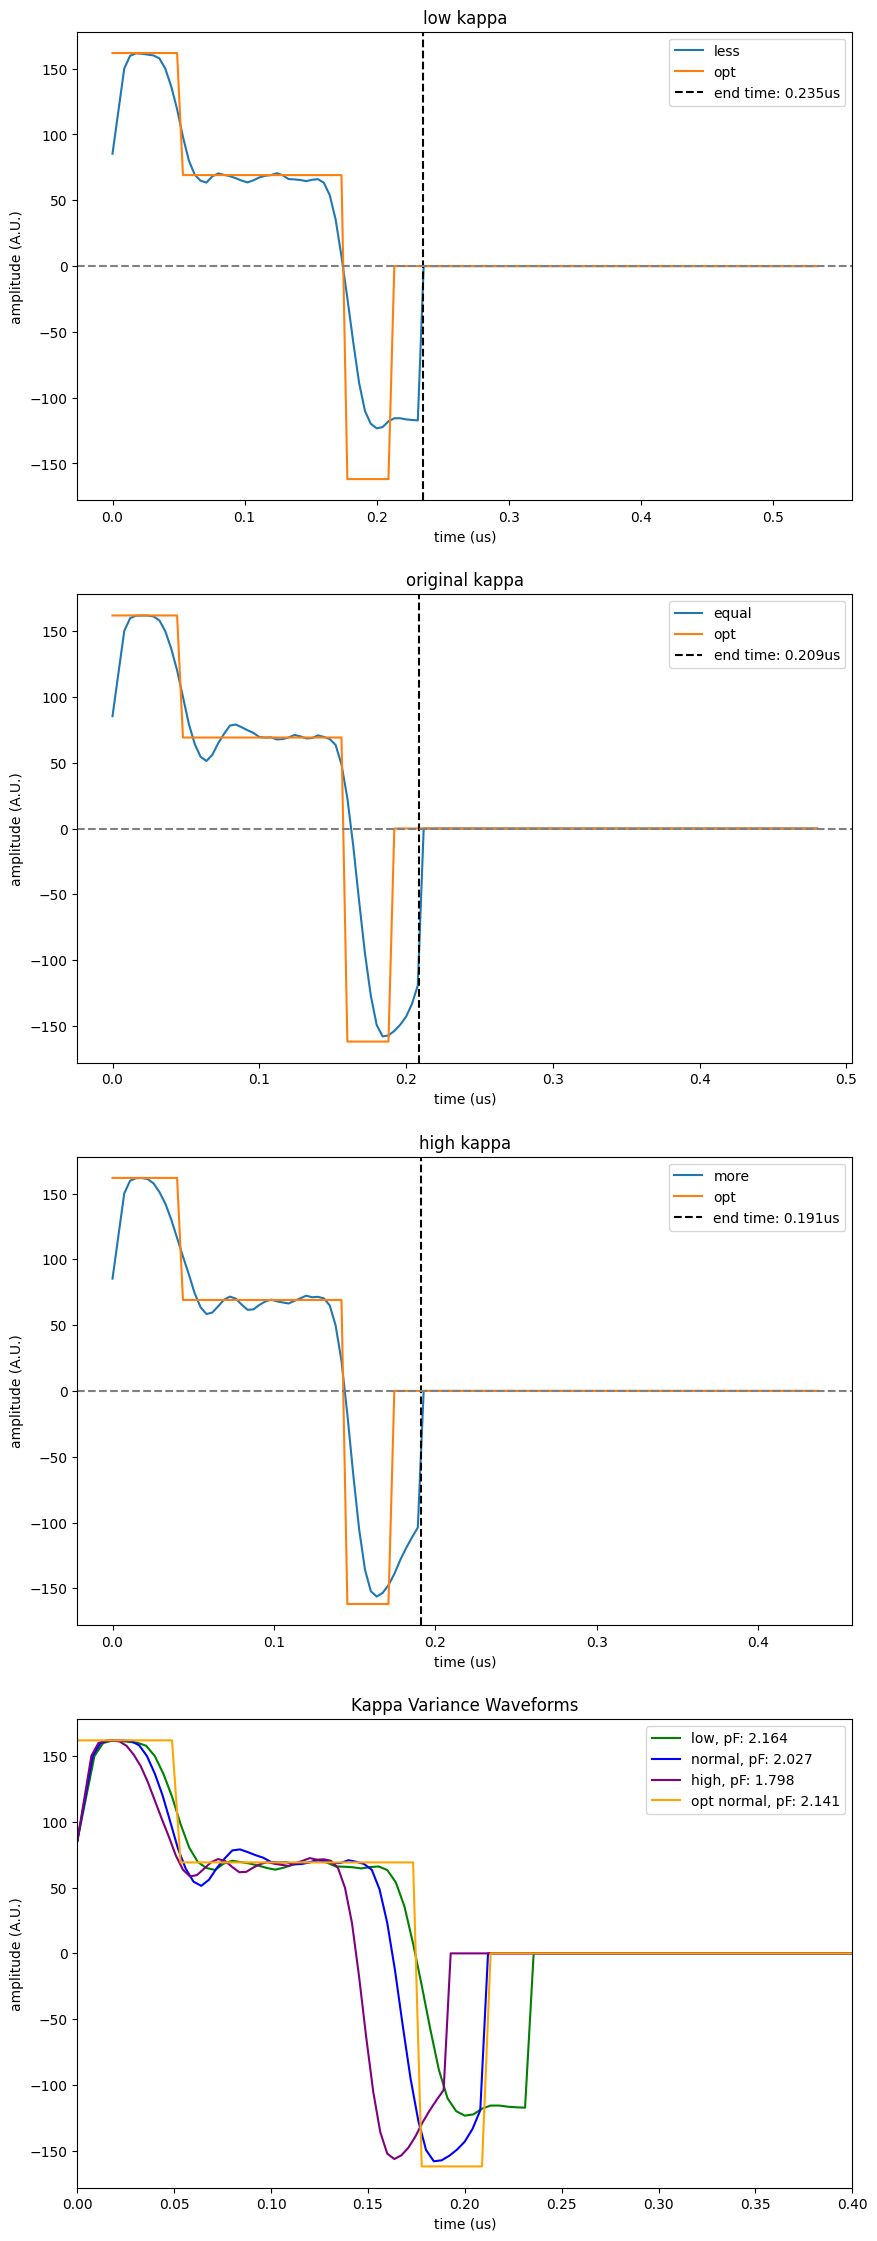

In [32]:
fig, ax = plt.subplots(4, figsize=(10., 28.))

assert ts_low.all() == low_ts.all()
assert ts_og.all() == normal_ts.all()
assert ts_high.all() == high_ts.all()

l = 5

kappa_action_low = -low_action
kappa_action_low = jnp.convolve(kappa_action_low, jnp.ones(l) / l, mode="same")
kappa_time_low = max_times[0, -1, ind]
kappa_action_low *= jnp.heaviside(kappa_time_low - ts_low, 0.)

kappa_action_normal = normal_action
kappa_action_normal = jnp.convolve(kappa_action_normal, jnp.ones(l) / l, mode="same")
kappa_time_normal = max_times[1, -1, ind]
kappa_action_normal *= jnp.heaviside(kappa_time_normal - ts_og, 0.)

kappa_action_high = -high_action
kappa_action_high = jnp.convolve(kappa_action_high, jnp.ones(l) / l, mode="same")
kappa_time_high = max_times[2, -1, ind]
kappa_action_high *= jnp.heaviside(kappa_time_high - ts_high, 0.)

ax[0].plot(ts_low, kappa_action_low, label='less')
ax[0].plot(ts_low, low_kappa_A3R, label='opt')
ax[0].axvline(x=kappa_time_low, label=f'end time: {int(kappa_time_low * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[0].set_xlabel('time (us)')
ax[0].set_ylabel('amplitude (A.U.)')
ax[0].set_title('low kappa')
ax[0].axhline(y=0, linestyle='dashed', color='grey')
ax[0].legend()

ax[1].plot(ts_og, kappa_action_normal, label='equal')
ax[1].plot(ts_og, normal_kappa_A3R, label='opt')
ax[1].axvline(x=kappa_time_normal, label=f'end time: {int(kappa_time_normal * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[1].set_xlabel('time (us)')
ax[1].set_ylabel('amplitude (A.U.)')
ax[1].set_title('original kappa')
ax[1].axhline(y=0, linestyle='dashed', color='grey')
ax[1].legend()

ax[2].plot(ts_high, kappa_action_high, label='more')
ax[2].plot(ts_high, high_kappa_A3R, label='opt')
ax[2].axvline(x=kappa_time_high, label=f'end time: {int(kappa_time_high * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[2].set_xlabel('time (us)')
ax[2].set_ylabel('amplitude (A.U.)')
ax[2].set_title('high kappa')
ax[2].axhline(y=0, linestyle='dashed', color='grey')
ax[2].legend()

ax[3].plot(ts_low, kappa_action_low, label=f'low, pF: {int(max_pFs[0, -1, ind] * 1e3) / 1e3}', color='green')
ax[3].plot(ts_og, kappa_action_normal, label=f'normal, pF: {int(max_pFs[1, -1, ind] * 1e3) / 1e3}', color='blue')
ax[3].plot(ts_high, kappa_action_high, label=f'high, pF: {int(max_pFs[2, -1, ind] * 1e3) / 1e3}', color='purple')
ax[3].plot(ts_low, normal_kappa_A3R, label='opt normal, pF: 2.141', color='orange')
ax[3].set_xlabel('time (us)')
ax[3].set_ylabel('amplitude (A.U.)')
ax[3].set_title('Kappa Variance Waveforms')
ax[3].legend()
ax[3].set_xlim(left=0., right=0.4)

plt.show()

Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


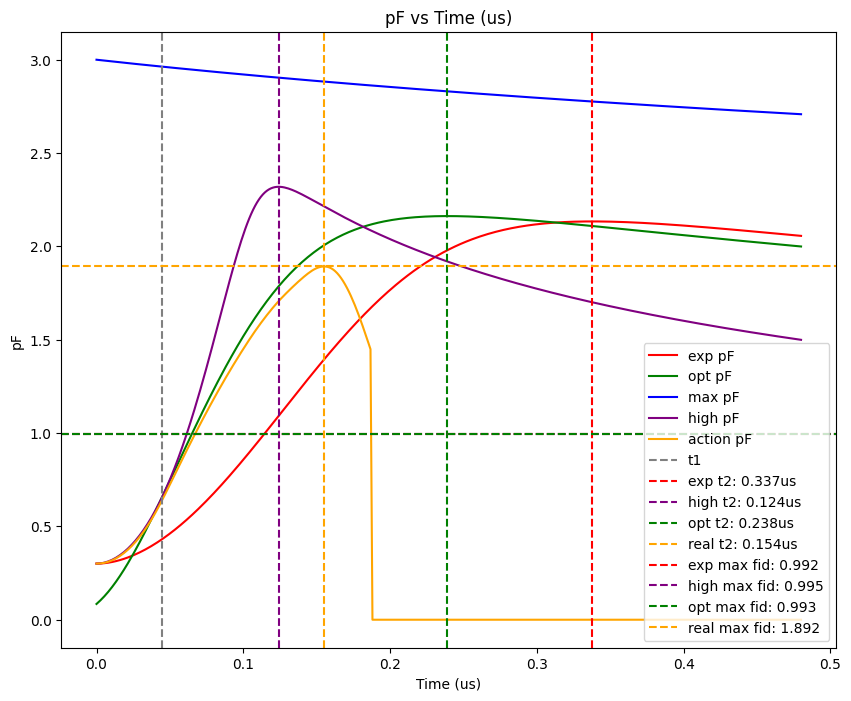

t1: 0.04455366098237813, t2: 0.23866666666666667, t3: 0.028613955541745277
Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


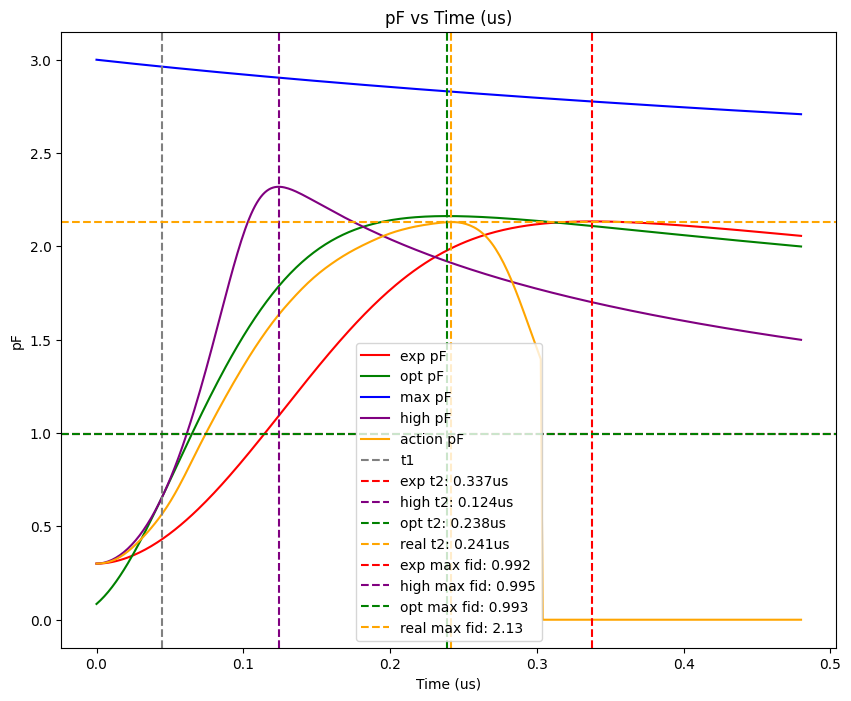

t1: 0.04455366098237813, t2: 0.23866666666666667, t3: 0.028613955541745277
Kappa: 25.0 MHz
1/kappa: 40.0ns
Normal Measurement Duration: 398.0ns
High Amp Duration (T1): 44.55366098237813ns


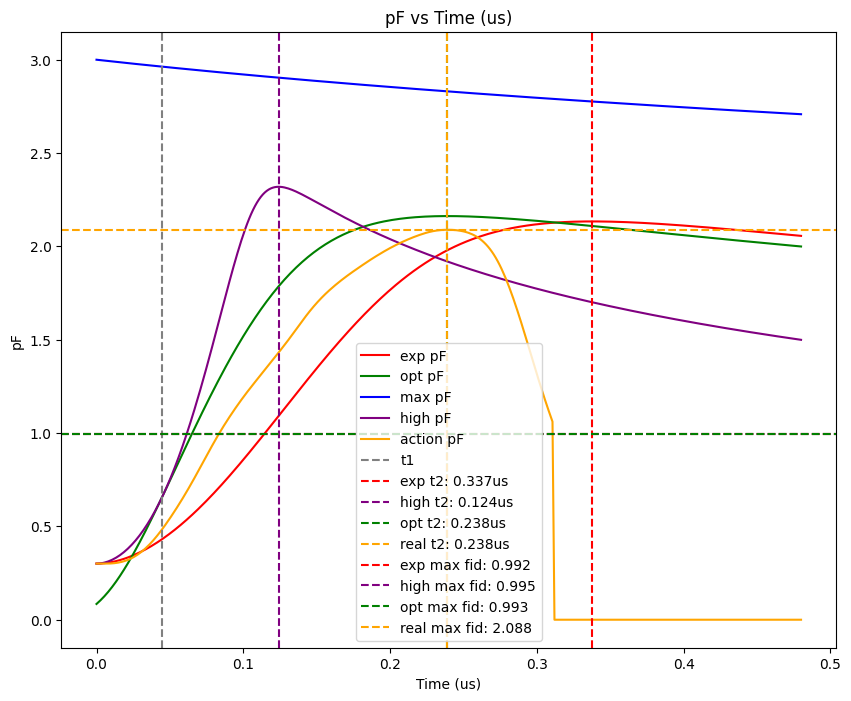

In [33]:
ind = 0
ts = jnp.linspace(0., num_t1 / kappa, 121)

plot_curves = True

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=-chi_max_actions[0, -1, ind]
)
print(f"t1: {t1}, t2: {t2}, t3: {t3}")
low_chi_A3R, low_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=-chi_max_actions[1, -1, ind]
)

print(f"t1: {t1}, t2: {t2}, t3: {t3}")
normal_chi_A3R, normal_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

t1, t2, t3 = get_fidelity_curves(
    kappa=kappa,
    chi=chi,
    N0=rough_max_photons,
    res_scale_factor=rough_max_amp_scaled,
    tau_0=tau_0,
    init_fid=init_fid,
    gamma_M=gamma_I,
    b=photon_gamma,
    mu_s=scaling_factor,
    num_t1=num_t1,
    plot_curves=plot_curves,
    action=chi_max_actions[2, -1, ind]
)
high_chi_A3R, high_ts = generate_A3R_waveform(
    kappa=kappa,
    chi=chi,
    tau_0=tau_0,
    t1=t1,
    t2=t2,
    t3=t3,
    N0=rough_max_photons,
    u=rough_max_amp_scaled,
)

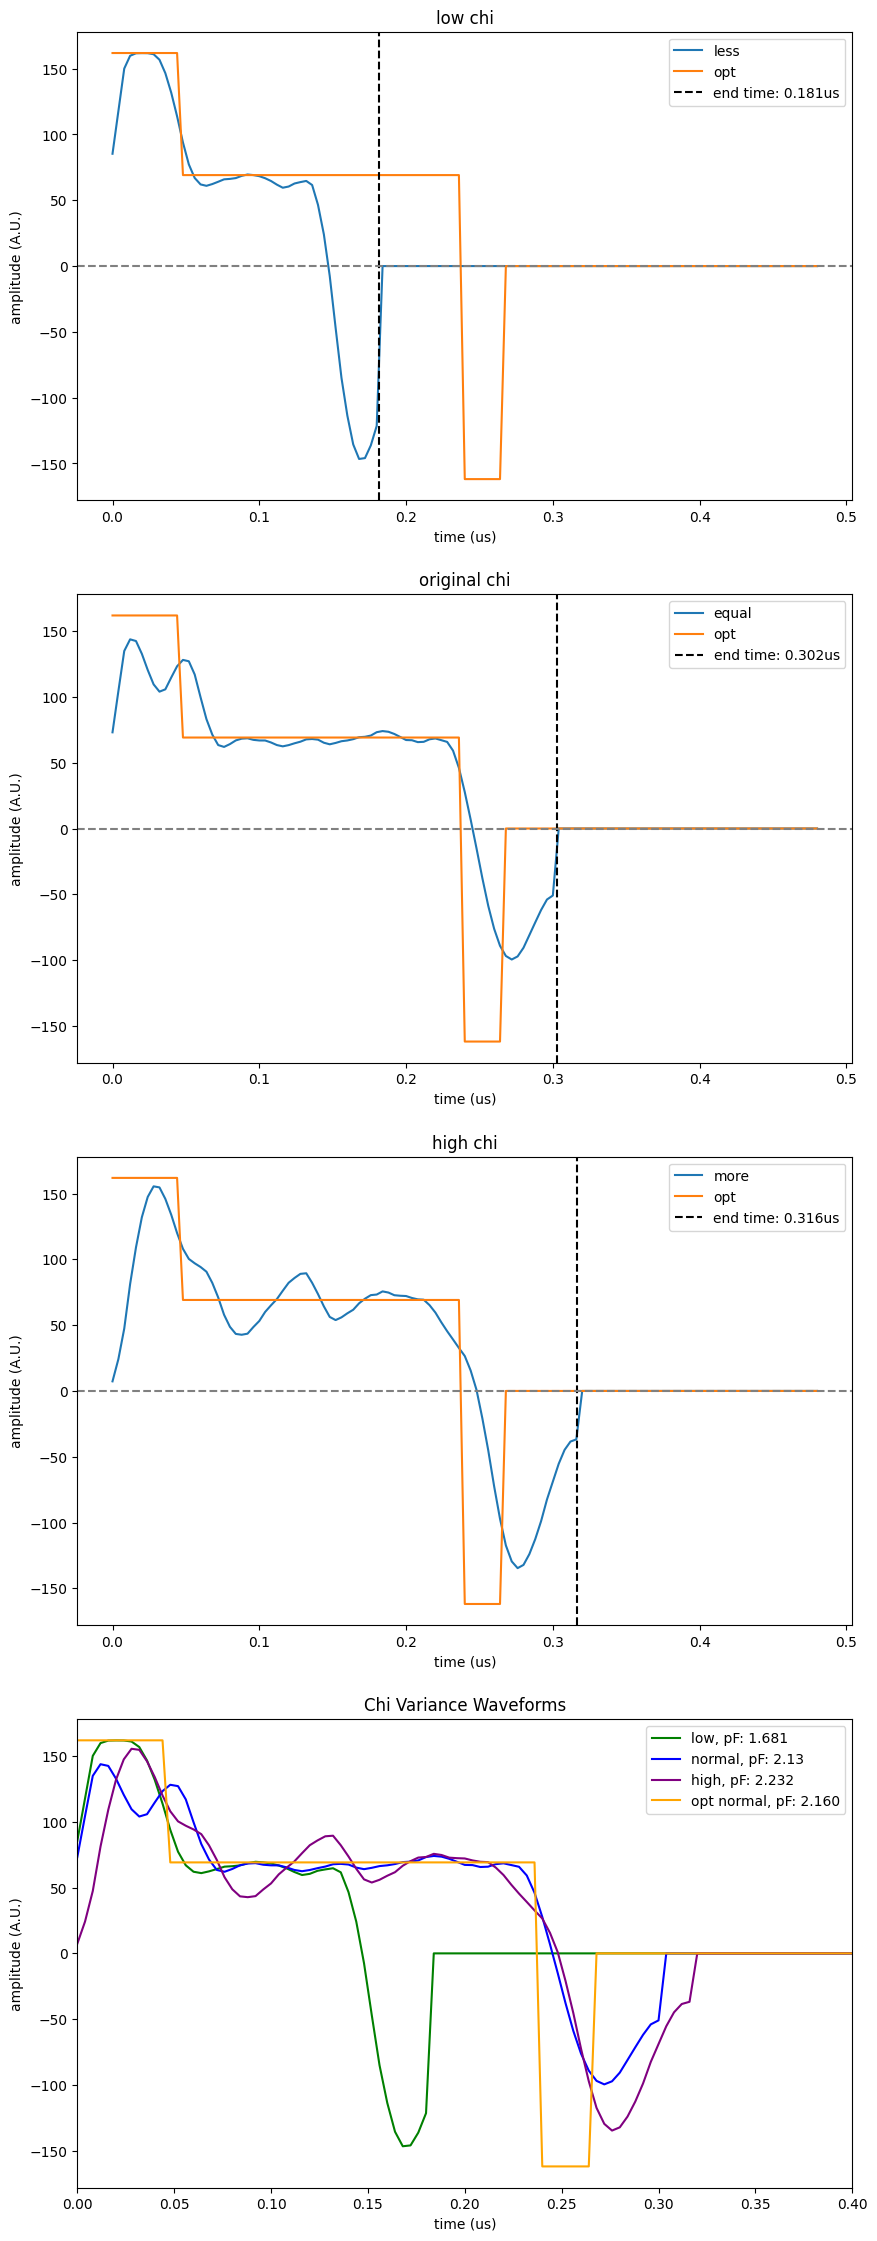

In [38]:
fig, ax = plt.subplots(4, figsize=(10., 28.))

chi_action_low = chi_max_actions[0, -1, ind]
chi_time_low = chi_max_times[0, -1, ind]
chi_action_low = jnp.convolve(chi_action_low, jnp.ones(l) / l, mode="same")
chi_action_low *= jnp.heaviside(chi_time_low - ts, 0.)

chi_action_normal = chi_max_actions[1, -1, ind]
chi_time_normal = chi_max_times[1, -1, ind]
chi_action_normal = jnp.convolve(chi_action_normal, jnp.ones(l) / l, mode="same")
chi_action_normal *= jnp.heaviside(chi_time_normal - ts, 0.)

chi_action_high = -chi_max_actions[2, -1, ind]
chi_time_high = chi_max_times[2, -1, ind]
chi_action_high = jnp.convolve(chi_action_high, jnp.ones(l) / l, mode="same")
chi_action_high *= jnp.heaviside(chi_time_high - ts, 0.)

ax[0].plot(ts, chi_action_low, label='less')
ax[0].plot(ts, low_chi_A3R, label='opt')
ax[0].axvline(x=chi_time_low, label=f'end time: {int(chi_time_low * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[0].set_xlabel('time (us)')
ax[0].set_ylabel('amplitude (A.U.)')
ax[0].set_title('low chi')
ax[0].axhline(y=0, linestyle='dashed', color='grey')
ax[0].legend()

ax[1].plot(ts, chi_action_normal, label='equal')
ax[1].plot(ts, normal_chi_A3R, label='opt')
ax[1].axvline(x=chi_time_normal, label=f'end time: {int(chi_time_normal * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[1].set_xlabel('time (us)')
ax[1].set_ylabel('amplitude (A.U.)')
ax[1].set_title('original chi')
ax[1].axhline(y=0, linestyle='dashed', color='grey')
ax[1].legend()

ax[2].plot(ts, chi_action_high, label='more')
ax[2].plot(ts, high_chi_A3R, label='opt')
ax[2].axvline(x=chi_time_high, label=f'end time: {int(chi_time_high * 1e3)/1e3}us', linestyle='dashed', color='black')
ax[2].set_xlabel('time (us)')
ax[2].set_ylabel('amplitude (A.U.)')
ax[2].set_title('high chi')
ax[2].axhline(y=0, linestyle='dashed', color='grey')
ax[2].legend()

ax[3].plot(ts, chi_action_low, label=f'low, pF: {int(chi_max_pFs[0, -1, ind] * 1e3) / 1e3}', color='green')
ax[3].plot(ts, chi_action_normal, label=f'normal, pF: {int(chi_max_pFs[1, -1, ind] * 1e3) / 1e3}', color='blue')
ax[3].plot(ts, chi_action_high, label=f'high, pF: {int(chi_max_pFs[2, -1, ind] * 1e3) / 1e3}', color='purple')
ax[3].plot(ts, normal_chi_A3R, label='opt normal, pF: 2.160', color='orange')
ax[3].set_xlabel('time (us)')
ax[3].set_ylabel('amplitude (A.U.)')
ax[3].set_title('Chi Variance Waveforms')
ax[3].legend()
ax[3].set_xlim(left=0., right=0.4)

plt.show()

In [4]:
batch_size = 1

env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batch_size,
    kerr=kerr,
    gamma=gamma,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    rough_max_photons=rough_max_photons,
    actual_max_photons=actual_max_photons,
    rough_max_amp_scaled=rough_max_amp_scaled,
    ideal_photon=ideal_photon,
    scaling_factor=scaling_factor,
    gamma_I=gamma_I,
    num_t1=num_t1,
    photon_gamma=photon_gamma,
    init_fid=init_fid
)

In [5]:
# normed_action = chi_max_actions[1, -1, ind] / env.max_signal_amp / env.res_amp_scaling
# smoothness = env.calculate_batch_smoothness(normed_action)
standard_smoothness = env.get_baseline_smoothness()
print(f"standard smoothness: {standard_smoothness}")
# print(f"new smoothness: {smoothness}")

standard smoothness: 0.0003080556967277469


smoothness bef: 0.0003080556967277469
smoothness aft: 0.0003080556967277469


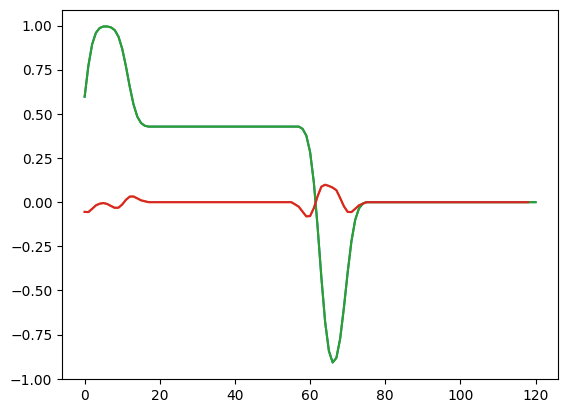

In [6]:
t1 = -2 / env._kappa * jnp.log(1.0 - 1 / env.max_signal_amp)
t2 = 0.25
t3 = (
    -2
    / env._kappa
    * jnp.log(env.max_signal_amp / (1.0 + env.max_signal_amp))
)
signal = jnp.heaviside(t1 - env.ts_action, 0.0)
signal += (
    1
    / env.max_signal_amp
    * (
        jnp.heaviside(t2 - env.ts_action, 0.0)
        - jnp.heaviside(t1 - env.ts_action, 0.0)
    )
)
signal -= jnp.heaviside(t2 + t3 - env.ts_action, 0.0) - jnp.heaviside(
    t2 - env.ts_action, 0.0
)
signal2 = env.drive_smoother(signal)

# temp_dt = env.ts_[1] - ts[0]
kernel_len = 11
std = 2.
small_ts = jnp.linspace(-0.5 * (kernel_len - 1), 0.5 * (kernel_len - 1), kernel_len)
gauss_func = 1 / jnp.sqrt(2 * jnp.pi * std**2) * jnp.exp(-(small_ts / jnp.sqrt(2 * std**2))**2)
# gauss_func /= trapezoid(gauss_func, x=small_ts)
signal = jnp.convolve(signal, gauss_func, mode='same')

# signal = jnp.convolve(signal, jnp.ones())
plt.plot(signal)
first_grad = jnp.diff(signal)
second_grad = jnp.diff(first_grad)
plt.plot(second_grad)

plt.plot(signal2)
first_grad = jnp.diff(signal2)
second_grad = jnp.diff(first_grad)
plt.plot(second_grad)

# plt.plot(normed_action)
# first_grad = jnp.diff(normed_action)
# second_grad = jnp.diff(first_grad)
# plt.plot(second_grad)

print(f"smoothness bef: {env.calculate_batch_smoothness(signal2)}")
print(f"smoothness aft: {env.calculate_batch_smoothness(signal)}")
# print(f"smoothness from RL: {env.calculate_batch_smoothness(normed_action)}")